In [101]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np
import time

from scipy.special import gamma, gammaln
from mpmath import mp, gamma
mp.dps = 10  # You can set this to be high enough to handle the precision you need


In [102]:
def gamma_function(z):
    gamma_result = gamma(mp.mpf(str(z)))
    return gamma_result

In [103]:
def getPower(n, step, scheme, p_min, p_max):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += p_min + ((p_max-p_min)/(step-1)) * (i)
        return power_sum / step
    else:
        return p_min + ((p_max-p_min)/(step-1)) * (n-1)

In [104]:
# [10.0, 70.0, 130.0, 190.0, 250.0]
getPower(n=1, step=5, scheme=1, p_min=10, p_max=250)

130.0

## Capture probability function

In [105]:
# only consider x capture
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)

    if slope_1 >= 1 :
        result = (1 / ((Pr * Py / Px)**(1 / gamma)) / 2)
    elif slope_1 <= 1:
        result = 1 - ((Pr*Py/Px)**(1 / gamma)) / 2
    return result

## Gereral analytical

In [106]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
            
#             counter_power += M_i_s[i][n] * 1 * n
            counter_power += M_i[i][n] * 1


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    success_probability = success_packet / sta_amount
    access_delay = (TXOP * counter_delay_slot) / success_packet
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Random analytical (scheme 1)

In [107]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_random(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    capture_prob = 0
    for n1 in range(1, Lmax+1):
        for n2 in range(1, Lmax+1):
            # P is the power of two station
            P1 = getPower(n=n1, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            P2 = getPower(n=n2, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            capture_prob += P_cap(P1, P2, CR, gamma) * (1 / Lmax) * (1 / Lmax)

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                # gamma
#                 M_i_s[i][n] += (capture_prob * 2) * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] += (capture_prob * 2) * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                # n=2 no gamma
                M_i_s[i][n] += (capture_prob * 2) * ((M_i[i][n] / M[i]) ** 2) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += (capture_prob * 2) * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=1, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Transmit-based analytical (scheme 2)

In [108]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_rampup(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if M[i] > 0:
                capture_prob_n_k = 0
                capture_prob_n2 = 0
                Pn = getPower(n=n, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
                
                capture_prob_n2 += P_cap(Pn, Pn, CR, gamma) * 2
                # calculate the capture prob. when n-th with k-th (K!=n)
                for k in range(1, Lmax+1):
                    Pk = getPower(n=k, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
                    if (n != k):
                        if (M[i] > M_i[i][n]):
#                             capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
                            capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
            
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n_k * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=2, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# Scenario I
Scenario III was designed to investigate the impact of transmit power levels $N$ on access success probability.

- Figure: $P_s$ for [$N=1$, $N=2$, $N=3$]
- Parameters: $R=128, C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (10-200)

In [109]:
R = [148]
# R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
CR = 3
N = 4
T_slot = 5.673

p_min = 10
p_max = 250

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

In [110]:
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

### Genral simu result

In [111]:
ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.9951550000000033, 0.8032966666666674, 0.4294125000000001, 0.20330399999999887, 0.09681833333333335, 0.04672571428571417, 0.023302499999999914, 0.011384444444444412, 0.005897999999999952]
da_list_simu_148 = [5.672999999999856, 5.735402999999855, 5.7599859999998575, 5.777950499999862, 5.8318439999998715, 5.850753999999871, 5.9104555714284315, 5.9396309999998955, 5.962322999999897, 6.033235499999913, 6.362269500000021, 6.740280399999999, 7.069550775000024, 7.4488759200000185, 7.778628500000003, 8.19521580000001, 8.513542012500055, 8.915812866666665, 9.299273062653057, 14.04194140099018, 17.836764838499256, 18.375816964324926, 18.028541577693446, 17.704704584891253, 17.473260247105767, 17.206154234582453, 17.269189892541746, 17.006939963311723]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.999599999999997, 39.80619999999981, 48.19779999999998, 34.35299999999999, 20.33039999999999, 11.618200000000007, 6.541599999999995, 3.7284000000000015, 2.049200000000002, 1.1795999999999975]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513243243243023, 0.26896081081080797, 0.32566081081081066, 0.23211486486486468, 0.13736756756756752, 0.07850135135135124, 0.044199999999999996, 0.025191891891891884, 0.013845945945946011, 0.007970270270270292]
power_list_simu_148 = [1.0, 1.011, 1.015333333333333, 1.0185, 1.027999999999999, 1.0313333333333343, 1.0418571428571455, 1.047, 1.0509999999999955, 1.0635000000000048, 1.1215000000000057, 1.1881333333333393, 1.2461750000000027, 1.313040000000002, 1.371166666666665, 1.4446000000000008, 1.5007125000000021, 1.571622222222224, 1.639318163265307, 2.4998915645223327, 4.384967877674983, 9.953864039782061, 23.004565477644185, 50.63815431181972, 108.58008540833075, 225.05152064799915, 492.6347755443622, 1028.6076920940166]

### random simu result

In [112]:
ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999995, 0.9933066666666719, 0.855787499999999, 0.5398739999999995, 0.28818833333333327, 0.1502528571428568, 0.07757249999999993, 0.04106555555555542, 0.02194499999999989]
da_list_simu_148_random = [5.672999999999856, 5.6900189999998565, 5.724056999999858, 5.728311749999864, 5.768306399999869, 5.774168499999862, 5.801858142857024, 5.82546187499989, 5.853905666666553, 5.851699499999907, 6.123719849999995, 6.330122499999993, 6.566497500000021, 6.766640940000013, 7.013057149999999, 7.240611985714272, 7.478148600000041, 7.718494700000009, 7.9601834099999875, 10.805561227386946, 14.55918318603129, 17.79347460534979, 18.61969885584665, 18.380517790909593, 17.973002848864926, 17.617969053265927, 17.41707780871471, 17.259028659316265]
t_list_simu_148_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.9998, 59.59840000000008, 68.46299999999995, 53.98740000000002, 34.582599999999985, 21.03540000000001, 12.4116, 7.391799999999998, 4.3889999999999985]
u_list_simu_148_random = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27026891891891447, 0.4026918918918913, 0.4625878378378379, 0.3647797297297296, 0.23366621621621664, 0.14213108108108088, 0.08386216216216195, 0.04994459459459449, 0.029655405405405354]
power_list_simu_148_random = [130.78, 129.73, 131.85, 131.1325, 129.148, 133.3683333333334, 133.56999999999996, 132.54875, 134.598888888889, 135.037, 139.7975, 145.2303333333334, 150.6685, 155.44779999999977, 161.03416666666664, 166.39928571428567, 171.462, 176.66433333333336, 182.61610000000005, 247.76757035175882, 338.20045035462476, 517.8961584278097, 983.7515948764457, 2037.1746596998432, 4123.847401501022, 8251.822912028552, 15996.727335594955, 30754.820173251424]

### Ramp Up simu result

In [113]:
ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9850333333333426, 0.8063874999999998, 0.4909440000000006, 0.26136166666666644, 0.13660714285714295, 0.0718099999999999, 0.03796666666666655, 0.020042999999999932]
da_list_simu_148_ramp = [5.672999999999856, 5.698528499999859, 5.707037999999857, 5.743912499999862, 5.776248599999869, 5.803478999999861, 5.816445857142733, 5.8410626249998865, 5.870294333333216, 5.906727599999917, 6.12315254999999, 6.3641604999999934, 6.623369325000026, 6.865918440000017, 7.108741749999994, 7.356908485714287, 7.580829900000035, 7.834097833333358, 8.092137389999987, 11.136438233939405, 15.02235342385712, 17.8447601361521, 18.507054544932366, 18.245789468653225, 17.864203184449828, 17.54959589468859, 17.343389801693824, 17.18270851687446]
t_list_simu_148_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.9984, 59.1019999999999, 64.51099999999994, 49.09439999999999, 31.36340000000004, 19.124999999999996, 11.489600000000017, 6.833999999999998, 4.008600000000004]
u_list_simu_148_ramp = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27025945945945506, 0.39933783783783655, 0.43588513513513516, 0.331718918918919, 0.21191486486486477, 0.12922297297297314, 0.07763243243243234, 0.046175675675675716, 0.027085135135135146]
power_list_simu_148_ramp = [10.0, 10.315, 10.42, 10.905, 11.274, 11.61999999999999, 11.77, 12.09625, 12.447777777777727, 12.884, 15.5935, 18.632333333333328, 22.04775, 25.307600000000022, 28.673833333333356, 32.32599999999992, 35.60725, 39.48744444444447, 43.62169999999996, 102.87900303030297, 214.7530163699514, 448.25830528461574, 991.271223554957, 2156.390224340601, 4446.255774200553, 8828.378524010413, 17278.23064335513, 33987.09585433266]

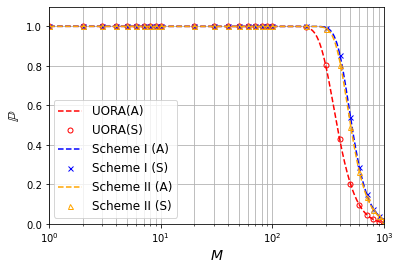

In [114]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{P}$", fontsize = 15)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.3), fontsize = 12)
plt.axis([1,sta_max,0.0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

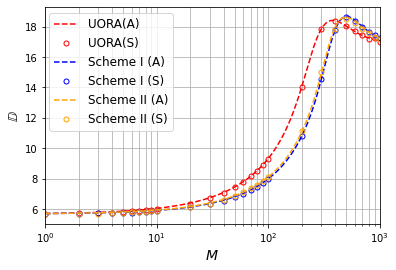

In [115]:
# general
plt.semilogx(m_list, da_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, da_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, da_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{D}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

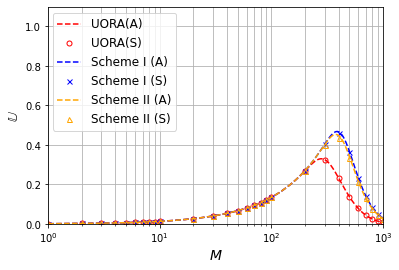

In [116]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, u_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping 
plt.semilogx(m_list, u_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, u_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

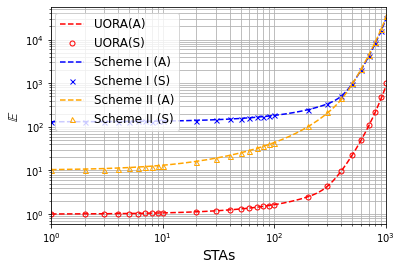

In [117]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.plot(m_list_simu, power_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.plot(m_list_simu, power_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# Scenario II ($R$ ---> $E$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $E$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

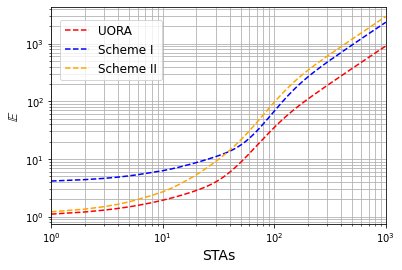

intersect at M=38


In [180]:
# R=9
# general
plt.plot(m_list, power_list[0], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[0], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if power_list_ramp[0][i] > power_list_random[0][i]:
        print(f'intersect at M={i+1}')
        break

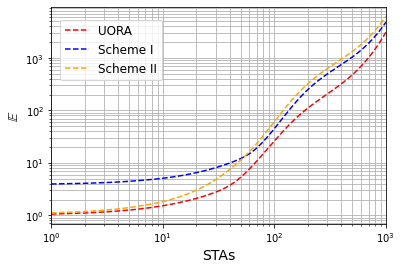

intersect at M=55


In [182]:
# R=18
# general
plt.plot(m_list, power_list[1], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[1], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if power_list_ramp[1][i] > power_list_random[1][i]:
        print(f'intersect at M={i+1}')
        break

# Scenario II ($R$ ---> $\mathbb{P}$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $\mathbb{P}$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

In [195]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
# ocw_max = 127
CR = 3
N = 4
T_slot = 5.673

p_min = 10
p_max = 250
# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

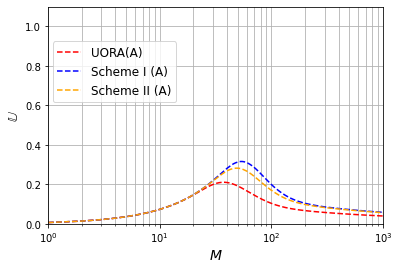

intersect at M=38
intersect at M=161


In [208]:
# U=9
index = 0
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# for i in range(1000):
#     if (u_list_ramp[index][i] - u_list[index][i]) > 0.01:
#         print(f'intersect at M={i+1}')
#         break

for i in range(1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break
        
for i in range(38, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break

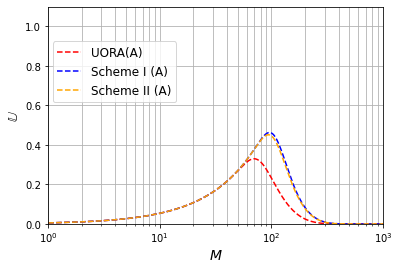

intersect at M=60
intersect at M=288


In [214]:
# U=37
index = 2
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if (u_list_random[index][i] - u_list[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break

for i in range(60, 1000):
    if (u_list_random[index][i] - u_list[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break
# for i in range(93, 1000):
#     if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
#         print(f'intersect at M={i+1}')
#         break

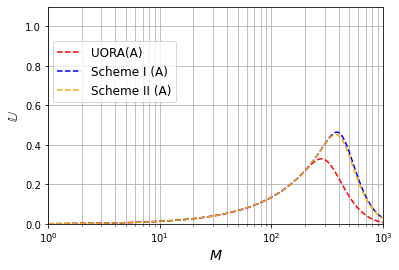

intersect at M=372
intersect at M=679


In [219]:
# U=37
index = 4
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# for i in range(1000):
#     if (u_list_random[index][i] - u_list[index][i]) > 0.01:
#         print(f'intersect at M={i+1}')
#         break

# for i in range(60, 1000):
#     if (u_list_random[index][i] - u_list[index][i]) < 0.01:
#         print(f'intersect at M={i+1}')
#         break
for i in range(0, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break
        
for i in range(678, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break

### Scenario III ($C$ ---> $E$)
Scenario III was designed to investigate the impact of capture threshold $C$ on power efficiency.

- Figure: $E$ for [$C=1.5$ dB, $C=6$ dB]
- Parameters: $R=128, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (1-200)

In [224]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
# ocw_max = 127
CR = 3
N = 2
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=10, p_max=250)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=10, p_max=250)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

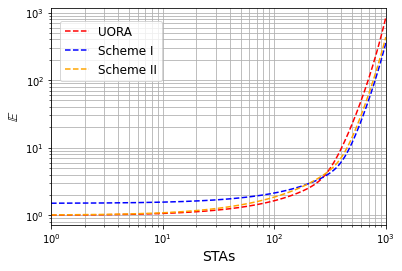

intersect at M=300


In [235]:
# R=9
index = 4
# general
plt.plot(m_list, power_list[index], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[index], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[index], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if (power_list_random[index][i] < power_list[index][i]) and (power_list_ramp[index][i] < power_list[index][i]):
        print(f'intersect at M={i+1}')
        break
